In [1]:
# This code is modified from "http://learn.neurotechedu.com/machinelearning/" 

# Turn off warnings 
# You'll want to comment this out if you plan on modifying this code, to get valuable feedback
import warnings
warnings.filterwarnings('ignore')

# Set-up

In [2]:
# import modules
from collections import OrderedDict
from pylab import rcParams
import torch
import torch.nn as nn
import torchvision.transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import csv
import random
import string


In [3]:
# # Uncomment below if needed: 
# # Set the randomizer seed for some consistency
# torch.manual_seed(100)

# Network 
Our Neural Network is going to be a simple Multi-Layer-Perceptron(MLP). 
So what is a MLP? Here are some resources to give you an understanding: 
1. https://machinelearningmastery.com/neural-networks-crash-course/
2. https://www.youtube.com/watch?v=u5GAVdLQyIg (literally my fav)

For our MLP, we want 3 sets of EEG data combined into a single sample; passed into the NN and for the NN to return if the data corresponds to Mind-Wandering or not. So, the structure of our MLP should be as follows:

Our MLP: 
24 neurons (input) -> 7 neurons (hidden layer) -> 6 neurons (hidden layer)  -> 5 neurons (output layer) -> 1(output)

The rationale for the input and output sizes are obvious enough (8*3 = 24 for input; we need one output -> is this mindwandering?) Yet you may ask: 
    1. Why 2 hidden layers? 
    2. Why the number of neurons for each layer?

I chose these hyper-parameters simply by trial and error. I had two things to balance. I needed sufficiently large number of neurons and layers to be able to be sensitive to Mind-Wandering. I also needed it to be sufficiently small to fit onto the Arduino Uno. This configuration was the sweet-spot I managed to hit. 

Let's first innitialize these parameters:

In [4]:
# Innitialize parameters
eeg_sample_length = 3*8  # No. of data points in 1 sample = no. of readings * no. of EEG data points in one reading
learning_rate = 6e-3     # How hard the network will correct its mistakes while learning
number_of_classes = 1    # no. of binary questions we want answered: is this mindwander?
hidden1 = 7              # Number of neurons in our first hidden layer
hidden2 = 6              # Number of neurons in our second hidden layer
output = 5               # Number of neurons in our output layer

Now, we make the network. We are going to be using pyTorch to do so. We have imported torch.nn as nn. I.e. we can access torch.nn (the pyTorch module for Neural Networks) as nn. 

First we use nn.sequential to build a Neural Network model: nn.sequential takes in modules and adds them to the model in the order that they are passed in: https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html

These modules can be a layers of neurons, activation functions for layers of neurons, etc. We are going to have 4 layers (in addition, to the input and output) with activation for each layer.

The following block of code achieves this: 

In [5]:
# Define the network 

nn_model = nn.Sequential() # Innit model 

# Add Input layer (Size 24 -> 7)
nn_model.add_module('InputLinear', nn.Linear(eeg_sample_length, hidden1))
nn_model.add_module('InputActivation', nn.ELU()) 

# Add Hidden layer (Size 7 -> 6)
nn_model.add_module('HiddenLinear', nn.Linear(hidden1, hidden2))
nn_model.add_module('HiddenActivation', nn.ReLU())

# Add Hidden Layer (Size 6 -> 5)
nn_model.add_module('HiddenLinear2', nn.Linear(hidden2, output))
nn_model.add_module('HiddenActivation2', nn.ReLU())


# Add Output Layer (Size 5 -> 1)
nn_model.add_module('OutputLinear', nn.Linear(output, number_of_classes))
nn_model.add_module('OutputActivation', nn.Sigmoid())



Once we have out NN model, we have to define a 
1. Loss function: This function helps a NN learn. It calculates the difference between the expected output and the NN's current given output for the same input. Minimizing this is the goal of training. 

2. Training function: This is the function that actually trains the NN. It iterates over a large number and changes the weights in an attempt to minimize the output of the loss function. The goal is to hit loss = 0. 

In [6]:
# Define training and loss function 

# Loss function definition
loss_function = torch.nn.MSELoss() # common loss function available in pyTorch

# Trainig procedure definition
def train_network(train_data, actual_class, iterations):
    # Keep track of loss at every training iteration
    loss_data = []
    
    # Begin training for a certain amount of iterations
    for i in range(iterations):
        # Begin with a classification
        classification = nn_model(train_data)
        
        # Find out how wrong the network was
        loss = loss_function(classification, actual_class)
        loss_data.append(loss)
        
        # Zero out the optimizer gradients every iteration
        optimizer.zero_grad() # to prevent gradient explosion
        
        # Teach the network how to do better next time # Update weights
        loss.backward()
        optimizer.step()
        
    # Plot a nice loss graph at the end of training
    rcParams['figure.figsize'] = 10, 5
    plt.title("Loss vs Iterations")
    plt.plot(list(range(0, len(loss_data))), loss_data)
    plt.show()
    
# Save the network's default state so we can retrain from the default weights
torch.save(nn_model, "nn_model_default_state")
    
    

# Data Pre-Processing

We now have a Network and a function that can train it. Our next step is to actually train our network. Before this can be done, however, we need to be get our data to be in a format that can be fed into the network to train it. The next couple of blocks achieve this: 

In [7]:
# Retrieve data from CSV file 
data_path = "/Users/JoshetaaMacbookPro/Desktop/BCIProject/MindWanderData/dataCollection/EEGdata_mindWander.csv"
# ^^ Replace with the data path of YOUR csv file 

First step to be able to train our network is to create two data sets: 
    1. Mind-Wandering samples (posEvent)
    2. Non Mind-Wandering samples (negEvent)
 
Before we do that, we need to read our file, store it in a list/array to perform computations with, and filter out what we dont need. The next block of code demonstrates this:

In [8]:
# Splitting Data into positive and negative samples 

# Innitialize lists
data = []            # This will contain the data from the CSV file 
posEvents = []       # This will contain Mind-Wandering samples
negEvents = []       # This will contain non Mind-Wandering samples


with open(data_path, newline='') as csvfile:    # Open csv file 
    rawData = csv.reader(csvfile)
    for row in rawData: 
        data.append(row)                        # Update data[] with the lines from CSV file

del data[0]                       # Remove headers

for line in range(len(data)):     # Remove signal strength, attn, and meditatn values
    data[line] = data[line][3:]

### Remove Data that have button pressess 'too close' together (i.e. within 10 readings)###
buttonLines = []                    # Innitialize list 
for line in range(len(data)):       # Add line numebr to list if they have a "*" at the end
    if data[line][-1] == "*":
        buttonLines.append(line)
        
prevLine = buttonLines[0]          # Innitialize previous line
for line in buttonLines[1:]:       # Go through all the button lines 
    if line-prevLine < 10:         # If lines too close together
        del data[prevLine-5:line]  # remove the first button instance 
    prevLine = line                # reset previous line to current line




We have pre-processed our data. Now we can split the data into the two required classes: 
Mind Wandering V/S not.

In [9]:
for line in range(len(data)-6):
    sampleP = []   # Will contain positive samples
    sampleN = []   # Will contain negaiive samples
    
    if data[line][-1] == "*":              # for lines with button-press
        # POSITIVE EVENTS 
        del data[line][-1]
        sampleP.append(data[line-5:line])  # choose 5 seconds of data before button press
        del sampleP[0][3:5]                # delete last 2 seconds of data (reaction time)
        # make sample a single array
        sampleP = np.concatenate(np.squeeze(np.array(sampleP)), axis = 0) 
        sampleP = list(map(int, sampleP))  # converts elements from string to integer
        posEvents.append(sampleP)          # add sample to posEvents list

       
        # NEGATIVE EVENTS
        sampleN.append(data[line+1:line+6]) # choose 5 seconds of data after button press
        del sampleN[0][0:2]                 # delete first 2 seconds of data (reaction time)
        # make sample a single array
        sampleN = np.concatenate(np.squeeze(np.array(sampleN)), axis = 0)
        sampleN = list(map(int, sampleN))   # converts elements from string to integer
        negEvents.append(sampleN)           # add sample to negEvents list

    
# Prints number os pos and neg events found
print("posEv: {}, negEv: {} ".format(len(posEvents), len(negEvents)))
    
# create arrays of the events lists 
pos = np.array(posEvents)
neg = np.array(negEvents)

# Prints shape of events arrays
print("Pos shape: ", pos.shape)
print("Neg shape: ",neg.shape)

posEv: 73, negEv: 73 
Pos shape:  (73, 24)
Neg shape:  (73, 24)


Now that we have split our data into two data sets - pos and neg - we should be able to start training our Neural Network. However, for a good machine learning model (i.e. NN) we need to scale and normalize our data. Here's is a really good article that explains why: 

https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35#:~:text=Feature%20scaling%20is%20essential%20for,that%20calculate%20distances%20between%20data.&text=Therefore%2C%20the%20range%20of%20all,proportionately%20to%20the%20final%20distance.

In the next block of code, I use the standard scaling functionlity in scikit learn that we have imported to scale our data between (-1,1) and also to normalize it to get a mean of 0 and variance of 1.

As documented here: 
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
This is done using the following formula -

x = (x - mean)/standard deviation


In [10]:
## Standard Scalar 
eeg_data_scaler = StandardScaler()           # innit instance of scalar
conc = np.concatenate((pos,neg), axis=0)     # Create a set of all pos and neg data joined
scaled = eeg_data_scaler.fit_transform(conc) # Scale the set 
pos = np.split(scaled,2)[0]                  # Split scaled positive
neg = np.split(scaled,2)[1]                  # Split scaled negative 

means = list(eeg_data_scaler.mean_)          # Get a list of the means used in scaling 

scales = list(eeg_data_scaler.scale_)        # Get a list of the s.d. used in scaling   

print("Means: ", means)
print()
print("Scales: ", scales)


Means:  [763727.5, 305545.2191780822, 120259.80821917808, 108257.65753424658, 107781.88356164383, 93348.26712328767, 59532.41095890411, 41665.479452054795, 774772.5342465753, 307755.4315068493, 127224.13698630137, 99825.27397260274, 119648.16438356164, 111443.3493150685, 68701.67123287672, 47535.42465753425, 670013.2602739726, 336091.51369863015, 137296.18493150684, 111801.14383561644, 130838.75342465754, 114929.1095890411, 77775.83561643836, 57266.95205479452]

Scales:  [689481.9648178221, 344369.2637187367, 168157.14352828835, 164327.45929520408, 145694.50214552248, 121902.04244197278, 76709.82527794976, 60074.24470046851, 650649.7912980696, 364156.8012847353, 177017.4129349616, 129661.47426841634, 160570.00969977758, 159264.76036817252, 102066.6424713352, 64606.56944763643, 558380.868423735, 470732.73160098365, 224739.0479448347, 145396.46561295632, 177029.31711959356, 176695.24692303827, 127958.09637405365, 97400.32273555797]


We want to copy the means and scales into our arduino program to scale the input data with the same scaling used in training the NN. 

Now that we have scaled positive and negative event data, we need to convert them into a form that our pytorch NN model can take in as input. 


In [11]:
## Prepare the train and test tensors
# Params
percent = 50                                # You can change the percent of samples you want to test with
nTest = int((percent/100)*pos.shape[0])     # Define the number of testing  samples
nTrain = pos.shape[0]-nTest                 # Define number of training samples 


# Specify pos train and test samples
pos_train = pos[:nTrain]                  # list of samples to train 
pos_test = pos[nTrain:]                   # list of samples to test
pos_test = torch.tensor(pos_test).float() # Make test samples to a tensor

# Specify Neg train and test samples
neg_train = np.array(random.choices(neg, k=nTrain))  # list of samples to train 
neg_test = np.array(random.choices(neg, k=nTest))    # list of samples to test
neg_test = torch.tensor(neg_test).float()            # Make test samples to a tensor


# Combine everything into their final structures
training_data = torch.tensor(np.concatenate((pos_train, neg_train), axis = 0)).float()  # Train data 
positive_testing_data = torch.tensor(pos_test).float()                                  # Test pos data 
negative_testing_data = torch.tensor(neg_test).float()                                  # Test neg data 

# Print the size of each of our data structures
print("training data count: " + str(training_data.shape[0]))
print("positive testing data count: " + str(positive_testing_data.shape[0]))
print("negative testing data count: " + str(negative_testing_data.shape[0]))

# Generate training labels
labels = torch.tensor(np.zeros((training_data.shape[0],1))).float()
labels[0:nTrain+1] = 1.0
print("training labels count: " + str(labels.shape[0]))




training data count: 74
positive testing data count: 36
negative testing data count: 36
training labels count: 74


In [12]:
# Want to see example samples within the testing data set? 
# Here's how you can print the first four samples in each set: 
pos_test[:4]

tensor([[ 1.1999e+00,  1.9412e+00, -4.4360e-01, -1.0592e-01, -4.4011e-01,
         -3.3042e-01, -4.1873e-01, -5.5564e-01,  1.1092e+00,  1.1190e+00,
         -5.7833e-01,  8.0910e-01, -5.8992e-01, -3.2458e-01, -2.6332e-01,
         -5.7832e-01,  1.0491e+00, -2.5156e-01, -3.9398e-01, -2.5180e-02,
         -1.6684e-01, -4.0006e-01, -3.5726e-01, -4.8050e-01],
        [ 1.2732e-01, -7.5130e-01, -4.2242e-01, -5.1515e-01, -5.1084e-01,
         -5.0616e-01, -6.6003e-01, -6.4912e-01, -5.9091e-01, -5.1766e-01,
         -3.8391e-01, -2.6007e-01, -4.0460e-01, -5.1110e-01, -5.4679e-01,
         -5.3198e-01,  6.1999e-01, -4.7841e-01,  1.1131e-01,  9.0425e-01,
         -3.3753e-04, -1.4962e-01,  8.0984e-01,  5.5694e-01],
        [ 1.2749e+00,  1.6907e+00,  2.5244e+00,  3.3856e+00,  2.1601e+00,
          1.9974e+00,  2.1905e+00,  1.6628e+00,  2.3062e+00,  1.9150e+00,
          2.3816e+00,  4.1409e-01,  2.4560e+00,  1.6489e+00,  1.3398e+00,
          1.1826e+00, -9.9273e-02,  7.7425e-02, -5.7067e-02,  

In [13]:
neg_test[:4]

tensor([[ 2.1022e-01,  6.3051e-01, -1.4097e-01,  4.4141e-01, -1.7055e-01,
          1.5408e+00, -5.3546e-01, -2.8223e-01, -4.7515e-01, -5.7514e-01,
         -2.6085e-01, -2.1982e-01, -4.6189e-01, -3.6249e-01, -4.6594e-01,
         -4.2114e-01,  5.1400e+00,  2.3374e+00,  2.8826e+00,  1.8524e+00,
          1.7296e+00,  2.0706e+00,  3.8509e+00,  3.3352e+00],
        [-1.1077e+00, -8.8725e-01, -7.1516e-01, -6.5879e-01, -7.3977e-01,
         -7.6575e-01, -7.7606e-01, -6.9357e-01, -1.1907e+00, -8.4510e-01,
         -7.1870e-01, -7.6988e-01, -7.4514e-01, -6.9974e-01, -6.7311e-01,
         -7.3577e-01,  3.8983e-01, -9.3978e-02, -4.3248e-01, -6.6236e-01,
         -4.9392e-01, -1.8551e-01,  1.8634e-01, -2.0220e-01],
        [ 4.1181e-01,  4.1604e-01,  1.5473e-03,  1.7126e+00,  3.3784e-01,
          1.0831e+00,  3.6580e+00,  2.3020e+00,  2.4810e-01,  4.5308e-01,
         -2.4101e-01,  6.4038e-01, -2.1717e-02,  4.3586e-02, -1.5257e-01,
          3.8999e-02,  3.3261e-01, -1.7202e-01, -3.8095e-01, -

# Train
We are now ready to train the model! First we load the model. Then we define the optimizer(this is used in the training function that we defined) to be a common optimization algorithm from pyTorch (Adam). See more at https://pytorch.org/docs/stable/optim.html. Then, all that's left is to call our train function that we defined!  

Below is the loss graph for dataset training session


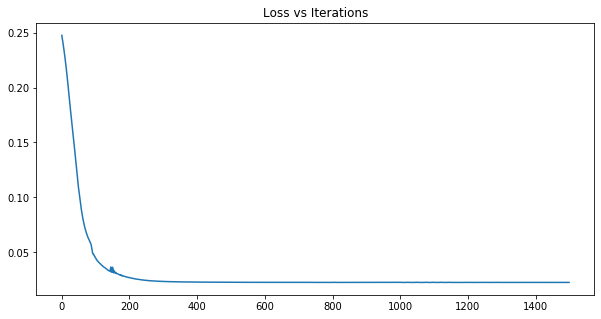

In [14]:
## TRAINING TIME 

# Make sure we're starting from untrained every time
nn_model = torch.load("nn_model_default_state")

# Define a learning function, needs to be reinitialized every load
optimizer = torch.optim.Adam(nn_model.parameters(), lr = learning_rate)

## Use our training procedure with the sample data
print("Below is the loss graph for dataset training session")
train_network(training_data, labels, iterations = 1500)



# Test
We are now ready to test the model. We just pass each one of our samples in the test data set through our trained network and visualize the results. We can also evaluate for model accuracy by dividing the number of correct classifications over all classifications in the testing.  

In [15]:
## TESTING TIME 
# Parameters 
corr = 0       # tracks number of correct classifications
thresh = 0.5   # threshold to classify as 'Mind-Wandering'
# if output is greater than 0.5, we reagrd it as a Mind-Wandering classification

# Classify our positive test dataset and print the results
classification_1 = nn_model(positive_testing_data)
for index, value in enumerate(classification_1.data.tolist()):
    print("Positive Classification {1}: {0:.2f}%".format(value[0] * 100, index + 1))
    # if output > 0.5; we have correctly classified mind-wandering
    if((value[0]) > thresh):   
        corr += 1

print()

# Classify our negative test dataset and print the results
classification_2 = nn_model(negative_testing_data)
for index, value in enumerate(classification_2.data.tolist()):
    print("Negative Classification {1}: {0:.2f}%".format(value[0] * 100, index + 1))
    # if output > 0.5; we have correctly classified non-mind-wandering
    if((value[0]) < thresh):
        corr += 1

accuracy = (corr/(positive_testing_data.shape[0]+negative_testing_data.shape[0])) * 100

print("\nClassification Accuracy: {:.2f}%".format(accuracy))


Positive Classification 1: 99.99%
Positive Classification 2: 99.73%
Positive Classification 3: 0.00%
Positive Classification 4: 99.68%
Positive Classification 5: 98.51%
Positive Classification 6: 99.86%
Positive Classification 7: 0.00%
Positive Classification 8: 99.97%
Positive Classification 9: 0.00%
Positive Classification 10: 99.70%
Positive Classification 11: 99.73%
Positive Classification 12: 99.98%
Positive Classification 13: 0.00%
Positive Classification 14: 0.00%
Positive Classification 15: 0.00%
Positive Classification 16: 99.02%
Positive Classification 17: 99.92%
Positive Classification 18: 2.51%
Positive Classification 19: 0.00%
Positive Classification 20: 100.00%
Positive Classification 21: 98.72%
Positive Classification 22: 98.40%
Positive Classification 23: 0.00%
Positive Classification 24: 99.84%
Positive Classification 25: 100.00%
Positive Classification 26: 99.96%
Positive Classification 27: 0.00%
Positive Classification 28: 0.00%
Positive Classification 29: 0.00%
Posi

The classification accurcay for this run seems to be about 65.28%. This is by no means perfect but it IS better than random chance. That is, our network IS predicting something. In fact working with the super rudimentary data we have (we only have 1 reading per second and are only using 3 readings as input) + low number of samples (we have less than a 100 training samples which is pretty low) used to train the network, the network seems to do a pretty good job. 


# Extracting Parameters 

Let's say I'm satisfies with this network (if not, I might re-run the optimzation or tweak some stuff - like collecting more data, tweaking NN architecture, etc), it's time for me to implement this network on the arduino. To do so, I need to know all the weights and biases of the network. The follwing blocks of code prints this out to the screen: 


In [16]:
print("Layer 1: Bias")
print(nn_model.InputLinear.bias)

print("\nLayer 2: Bias")
print(nn_model.HiddenLinear.bias)

print("\nLayer 3: Bias")
print(nn_model.HiddenLinear2.bias)

print("\nLayer 4: Bias")
print(nn_model.OutputLinear.bias)

Layer 1: Bias
Parameter containing:
tensor([ 0.4012, -0.1167, -0.2542,  0.0496,  0.5950,  0.1761,  0.0209],
       requires_grad=True)

Layer 2: Bias
Parameter containing:
tensor([ 0.8503, -0.3391,  0.1739, -0.0366,  0.0370,  0.5428],
       requires_grad=True)

Layer 3: Bias
Parameter containing:
tensor([-0.1854,  0.2801,  0.8478,  0.3902,  0.0883], requires_grad=True)

Layer 4: Bias
Parameter containing:
tensor([0.6722], requires_grad=True)


In [17]:
print("Layer 1: Weights ==> {}".format((torch.transpose(nn_model.InputLinear.weight,-2,1)).shape))
print(torch.transpose(nn_model.InputLinear.weight,-2,1))

print("\nLayer 2: Weights ==> {}".format((torch.transpose(nn_model.HiddenLinear.weight,-2,1)).shape))
print(torch.transpose(nn_model.HiddenLinear.weight,-2,1))

print("\nLayer 3: Weights ==> {}".format((torch.transpose(nn_model.HiddenLinear2.weight,-2,1)).shape))
print(torch.transpose(nn_model.HiddenLinear2.weight,-2,1))

print("\nLayer 4: Weights ==> {}".format((torch.transpose(nn_model.OutputLinear.weight,-2,1)).shape))
print(torch.transpose(nn_model.OutputLinear.weight,-2,1))

Layer 1: Weights ==> torch.Size([24, 7])
tensor([[ 0.2419, -0.2120, -0.3015, -0.2938,  0.4000, -0.1906,  0.0524],
        [ 0.4860,  0.2274,  0.2857, -0.1316,  0.0420, -0.2970,  0.3802],
        [ 0.1054, -0.8773, -0.7190, -0.4493,  0.1195,  0.5787,  0.1789],
        [ 0.3377, -0.2554, -0.2319,  0.0581,  0.7208,  0.0434, -0.3644],
        [-0.6364,  0.2855,  0.5553,  0.4399, -0.2728, -0.6831,  0.3790],
        [-0.5786, -0.0832, -0.1771,  0.0146,  0.7982, -0.4230,  0.0851],
        [-0.6120,  0.4741,  0.6472,  0.6094,  0.3961, -0.3929, -0.2151],
        [-0.0575,  0.0165, -0.2707, -0.2583,  0.1625, -0.3324,  0.3747],
        [-0.5528,  0.2760, -0.0938,  0.3043,  0.4574, -0.4488,  0.3860],
        [ 0.1573, -0.3626, -0.6732,  0.0294,  0.8808, -0.4776, -0.6726],
        [ 0.1288, -0.1322, -0.2696,  0.0162,  0.6736, -0.4281, -0.3111],
        [ 0.4333, -0.3831,  0.0370, -0.3131,  0.2161, -0.1263,  0.4449],
        [ 0.1381,  0.1912,  0.4022,  0.3933, -0.5933, -0.8646,  0.3262],
        [ 

# LE FIN